In [70]:
#Importing the neccesary library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_validate


In [34]:
#Importing the data
data = pd.read_csv("medical_insurance.csv", sep=",")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Preprocessing

In [35]:
#First look
print("Missing values :")
print(data.isna().sum(axis=0))
print()
print("Data types")
print(data.dtypes)
print()
print(data.describe())
for var in data.select_dtypes(include="object").columns.to_list():
    print()
    print(data[var].value_counts())

Missing values :
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Data types
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

               age          bmi     children       charges
count  2772.000000  2772.000000  2772.000000   2772.000000
mean     39.109668    30.701349     1.101732  13261.369959
std      14.081459     6.129449     1.214806  12151.768945
min      18.000000    15.960000     0.000000   1121.873900
25%      26.000000    26.220000     0.000000   4687.797000
50%      39.000000    30.447500     1.000000   9333.014350
75%      51.000000    34.770000     2.000000  16577.779500
max      64.000000    53.130000     5.000000  63770.428010

sex
male      1406
female    1366
Name: count, dtype: int64

smoker
no     2208
yes     564
Name: count, dtype: int64

region
southeast    766
southwest    684
northwest    

# Analyse descriptive

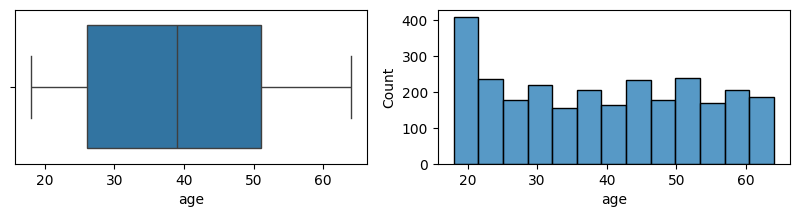

count    2772.000000
mean       39.109668
std        14.081459
min        18.000000
25%        26.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64


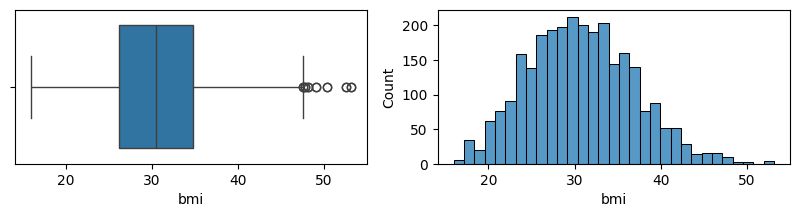

count    2772.000000
mean       30.701349
std         6.129449
min        15.960000
25%        26.220000
50%        30.447500
75%        34.770000
max        53.130000
Name: bmi, dtype: float64


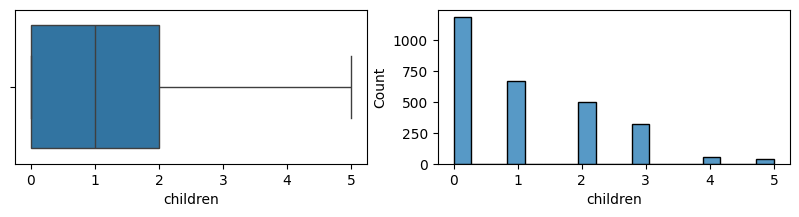

count    2772.000000
mean        1.101732
std         1.214806
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: children, dtype: float64


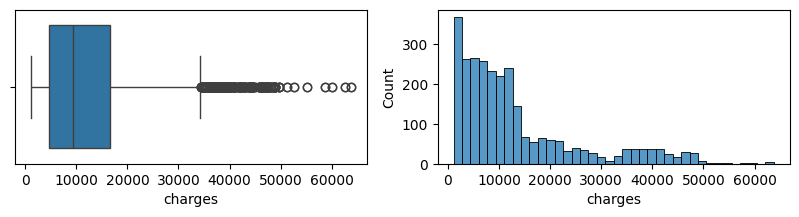

count     2772.000000
mean     13261.369959
std      12151.768945
min       1121.873900
25%       4687.797000
50%       9333.014350
75%      16577.779500
max      63770.428010
Name: charges, dtype: float64


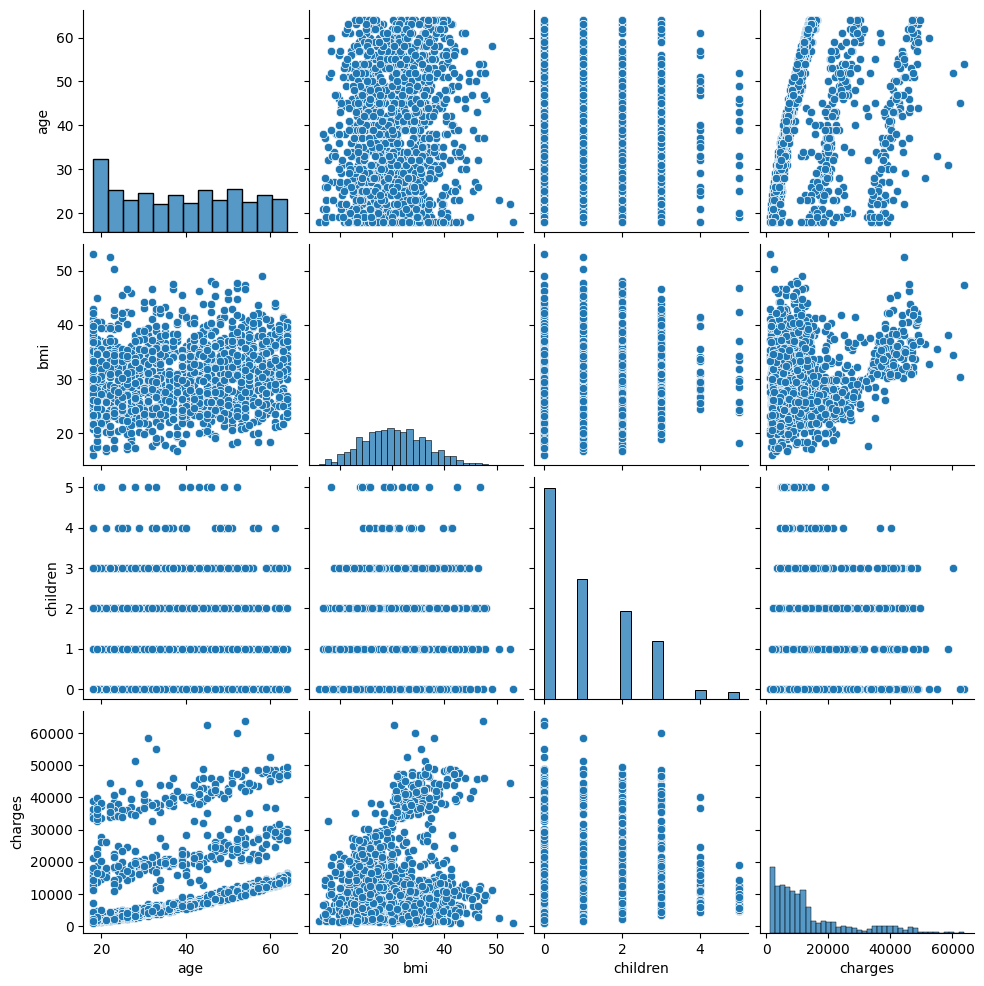

In [36]:
#Visualisation
for var in data.select_dtypes("number").columns:
    fig, axs = plt.subplots(1,2,figsize=(10,2))
    sns.boxplot(data, x = var, whis = 1.5, ax = axs[0])
    sns.histplot(data,x=var, ax = axs[1])
    plt.show()
    print(data[var].describe())

sns.pairplot(data)
plt.show()

[]

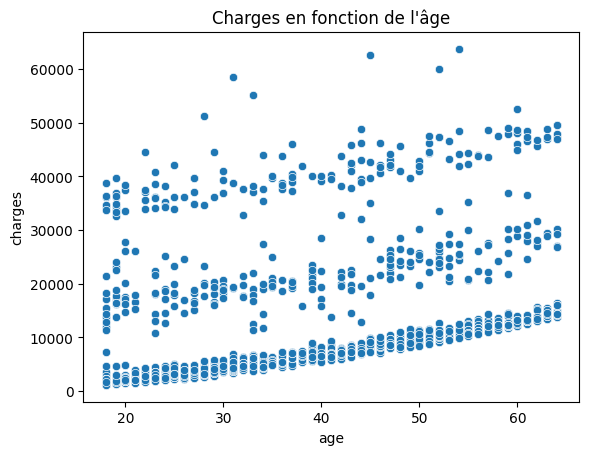

In [37]:
sns.scatterplot(data = data, y = "charges",x = "age")
plt.title("Charges en fonction de l'âge")
plt.plot()

On observe très clairement trois "traces" de points avec des charges clairement distinctes pour manifestement trois groupes d'individus.

[]

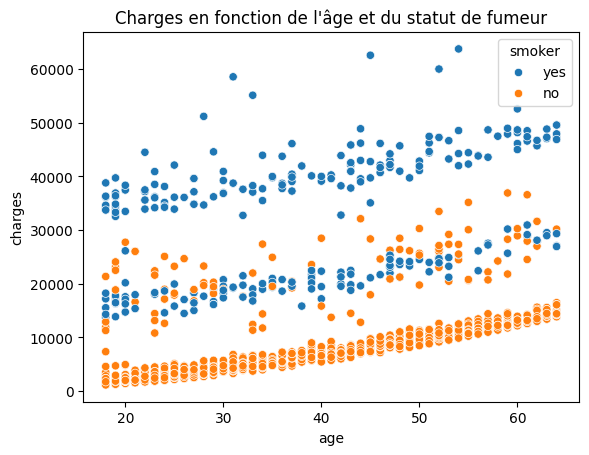

In [38]:
sns.scatterplot(data = data, y = "charges",x = "age",hue="smoker")
plt.title("Charges en fonction de l'âge et du statut de fumeur")
plt.plot()

Après plusieurs essais de coloration avec les variables catégorielles, on voit que le fait d'être fumeur influence clairement les charges de santé. \
Pour les "étages" 1 et 3, le phénomène est manifeste : être fumeur augmente les charges de santé (qui augmentent de toute façon avec l'âge).\
Cependant, pour l'étage 2, cela semble plus mitigé. Il faut donc explorer plus pour déterminer cet autre facteur.

In [39]:
import plotly.express as px

df = data.copy()

fig = px.scatter_3d(
    df,
    x="age",
    y="bmi",
    z="charges",
    color="smoker",          # coloration par catégorie
    symbol="smoker",         # symboles différents
    opacity=1,
    title="Charges en fonction de l'âge, du BMI et du statut de fumeur",
    size="charges",
    color_continuous_scale='Viridis'
)

fig.update_traces(marker=dict(size=4))
fig.show()

Pour le groupe intermédiaire, il semble y avoir une relation entre BMI et les charges. Plus il est élevé, les charges semblent l'être mais c'est à inspecter.\
Nous allons maintenant examiner les charges en fonction du BMI.

[]

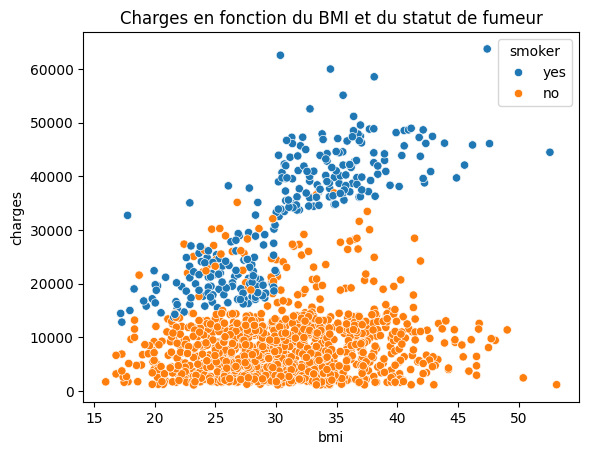

In [40]:
sns.scatterplot(data = data, y = "charges",x = "bmi",hue="smoker")
plt.title("Charges en fonction du BMI et du statut de fumeur")
plt.plot()

On peut très clairement voir que pour les fumeurs, les charges de santé augmente assez peu avec le BMI et reste à peu près constante mais que pour les fumeurs, \
plus le BMI est important, plus les charges de santé le seront. Cela peut indiquer un facteur de risque supplémentaire. 

In [41]:
#Relation entre les variables catégorielles
nom_var = ["sex","smoker","region"]
seuil_corr_nom = 0
for i,var in enumerate(nom_var):
    ct_tab = []
    cr_tab = []
    for j in range(i+1,len(nom_var)):
        #print("i :", i, " j :", j)
        ct_tab.append(pd.crosstab(index=data[nom_var[i]], columns=data[nom_var[j]]))
        cr_tab.append(stats.contingency.association(ct_tab[j-1-i],correction=False,method="cramer"))
        if(cr_tab[j-i-1] >= seuil_corr_nom):
            print("Coefficient de Cramér de", nom_var[i], "et", nom_var[j]," : ", cr_tab[j-i-1])


Coefficient de Cramér de sex et smoker  :  0.08232647745208163
Coefficient de Cramér de sex et region  :  0.024768087180991518
Coefficient de Cramér de smoker et region  :  0.07906136988750963


On observe pas de corrélations claires entre ces variables.

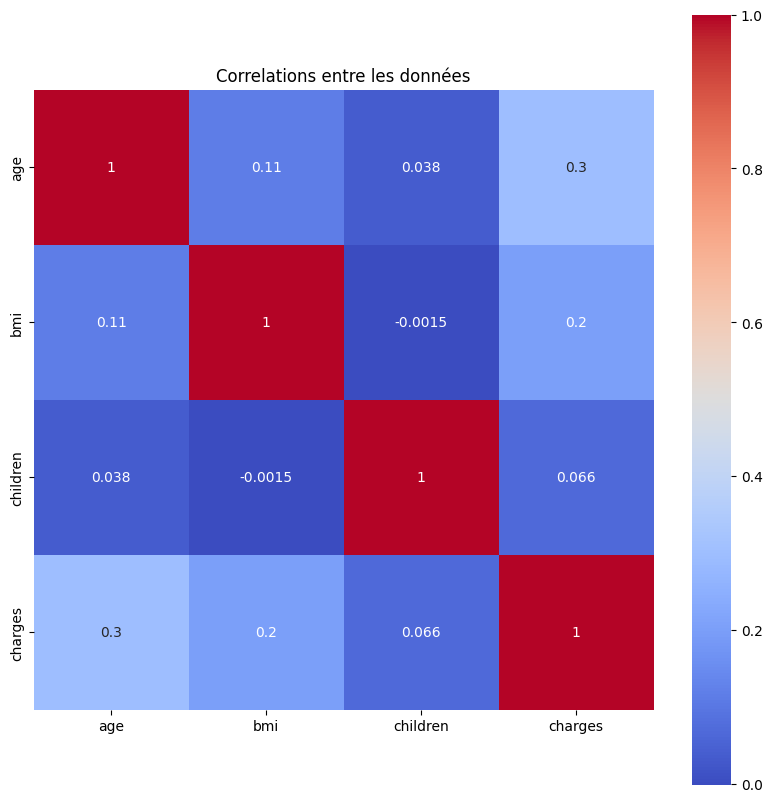

In [42]:
#Corrélations linéaires entre les variables numériques
X = data.select_dtypes("number")
X_corr = X.corr()
plt.figure(figsize=(10,10))
sns.heatmap(X_corr, annot=True,cmap = 'coolwarm', square=True)
plt.title('Correlations entre les données')
plt.show()

# from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, pairwise_kernels, sigmoid_kernel
# X_corr_rbf1 = pairwise_kernels(X,metric="linear")
# print(pd.DataFrame(X_corr_rbf1).corr())

# plt.figure(figsize=(10,10))
# sns.heatmap(X_corr, annot=True,cmap = 'coolwarm', square=True)
# plt.title('Correlations entre les données')
# plt.show()

Il en est de même pour les variables numériques : la heatmap ne montre pas de corrélation linéaire supérieure à 0.3 (charges et age).

In [43]:
#Encoding
#Since each categorical variable (3 of the six explaining variables) have only 2 (for sex and smoker) or 4 values (for region), we can do a one hot encoding.
#It will generate only 6 columns resulting in 9 columns used in total to predict the charges (we drop the 3 categorical variables and replace them with their dummies).
cat_var = data.select_dtypes("object").columns

encoder = OneHotEncoder(drop = "if_binary",sparse_output=False)
output = encoder.fit_transform(data[cat_var])
df_output = pd.DataFrame(output, columns=["sex_male","smoker_yes","region_northeast","region_northwest","region_southeast","region_southwest"])
df_output.shape 
# print(data.head())
# print(df_output.head())

data_processed = data.copy()
data_processed.drop(["sex","smoker","region"], axis=1, inplace=True)
data_processed[["sex_male","smoker_yes","region_northeast","region_northwest","region_southeast","region_southwest"]] = df_output
data_processed[["sex_male","smoker_yes","region_northeast","region_northwest","region_southeast","region_southwest"]] = data_processed[["sex_male","smoker_yes","region_northeast","region_northwest","region_southeast","region_southwest"]].astype(int)
data_processed.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,0,1,0,0


In [44]:
#Adding a constant columns 
data_processed["const"] = pd.Series(np.ones(shape=(2772,)))
cols = ['const'] + [col for col in data_processed.columns if col != 'const']
data_processed = data_processed[cols]
data_processed.head()

,const,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,1.0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,1.0,18,33.770,1,1725.55230,1,0,0,0,1,0
2,1.0,28,33.000,3,4449.46200,1,0,0,0,1,0
3,1.0,33,22.705,0,21984.47061,1,0,0,1,0,0
4,1.0,32,28.880,0,3866.85520,1,0,0,1,0,0


Faire beaucoup d'analyse descriptive 


# Model implementation

## Linear Model

In [45]:
#First LinearRegression => full model
y = data_processed["charges"]
X = data_processed.drop("charges", axis=1)

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

results = sm.OLS(y_train,X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     844.2
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:19:39   Log-Likelihood:                -22432.
No. Observations:                2217   AIC:                         4.488e+04
Df Residuals:                    2208   BIC:                         4.493e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -9682.7225    601.751  

On peut d'emblée voir que la variable sex (sex_male) n'est pas significative car sa p-value est de 0.8 soit bien plus que 0.05. \
On va vérifier les moyennes de charges pour chaque sex mais on ne la gardera pas dans les autres modèles. 

In [46]:
#Vérification numérique de l'influence de sex
moy_charges_male = data_processed[data_processed["sex_male"]==1]["charges"].mean()
moy_charges_female = data_processed[data_processed["sex_male"]==0]["charges"].mean()
print("Moyenne des charges pour les hommes :", moy_charges_male)
print("Moyenne des charges pour les femmes :",moy_charges_female)

med_charges_male = data_processed[data_processed["sex_male"]==1]["charges"].median()
med_charges_female = data_processed[data_processed["sex_male"]==0]["charges"].median()
print("Médiane des charges pour les hommes :",med_charges_male)
print("Médiane des charges pour les femmes :",med_charges_female)

Moyenne des charges pour les hommes : 14013.872721266001
Moyenne des charges pour les femmes : 12486.83197685066
Médiane des charges pour les hommes : 9361.3268
Médiane des charges pour les femmes : 9283.562


In [47]:
#Stepwise model selection : forward
y = data_processed["charges"]

col = data_processed.columns
col = col.drop("charges")
list_col = ["const"]
resumecustom = [[],[],[],[]]
for i,var in enumerate(col):
    if(var == "sex_male"):
        continue 
    if(i != 0):
        list_col.append(var) 
        
    # print("\nVariables used :")
    # print(list_col)
    X = data_processed[list_col]

    X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

    results = sm.OLS(y_train,X_train).fit()
    # list_col_string = "const,"
    # for i in range(len(list_col)):
    #     list_col_string = list_col_string + list_col[i]+ ","

    resumecustom[0].append(list_col[-1])
    resumecustom[1].append(results.rsquared)
    resumecustom[2].append(results.f_pvalue)
    resumecustom[3].append(results.aic)

    print(results.summary())

df_results = pd.DataFrame(np.transpose(resumecustom), columns=["Column added","R2","F-stat","AIC"])
df_results.head(10)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 30 Nov 2025   Prob (F-statistic):                nan
Time:                        22:19:39   Log-Likelihood:                -23985.
No. Observations:                2217   AIC:                         4.797e+04
Df Residuals:                    2216   BIC:                         4.798e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.337e+04    256.753     52.078      0.0

,Column added,R2,F-stat,AIC
0,const,3.3306690738754696e-16,nan,47972.47529546012
1,age,0.08027686460936756,3.34921898654967e-42,47788.95098451045
2,bmi,0.10592076211931911,1.490194520644532e-54,47728.25803611689
3,children,0.1091731416993943,3.4794943979037125e-55,47722.17858193749
4,smoker_yes,0.7521604593868949,0.0,44887.81847867935
5,region_northeast,0.7530679849149383,0.0,44881.68548748825
6,region_northwest,0.7535995533750951,0.0,44878.90782607847
7,region_southeast,0.7536063178697243,0.0,44880.846961373645
8,region_southwest,0.7536063178697243,0.0,44880.846961373645


On peut clairement voir que le R2 bondit après l'ajout de la variable smoker au modèle et que bmi, âge, children et sex n'ont que très peu d'influence (comme prévu pour sex). \
Nous allons essayer un modèle avec seulement age, bmi, et smoker afin de coller aux visualisations faites précédemment.

In [48]:
y = data_processed["charges"]
X = data_processed.drop("charges", axis=1)
X = X[["const","age","bmi","smoker_yes"]]

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

results = sm.OLS(y_train,X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     2214.
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:19:39   Log-Likelihood:                -22448.
No. Observations:                2217   AIC:                         4.490e+04
Df Residuals:                    2213   BIC:                         4.493e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.115e+04    723.310    -15.415      0.0

Nous avons donc le modèle : charges = -1115 + 256 x age + 307 x bmi + 23856 x smoker_yes sur deux graphes différents. \
Refaire

const         410.907926
age             9.653970
smoker_yes    330.560165
dtype: float64


C:\Users\ulyss\AppData\Local\Temp\ipykernel_19140\2056477574.py:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\ulyss\AppData\Local\Temp\ipykernel_19140\2056477574.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\ulyss\AppData\Local\Temp\ipykernel_19140\2056477574.py:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\ulyss\AppData\Local\Temp\ipykernel_19140\2056477574.py:13: FutureWarning:

Series.__ge

[]

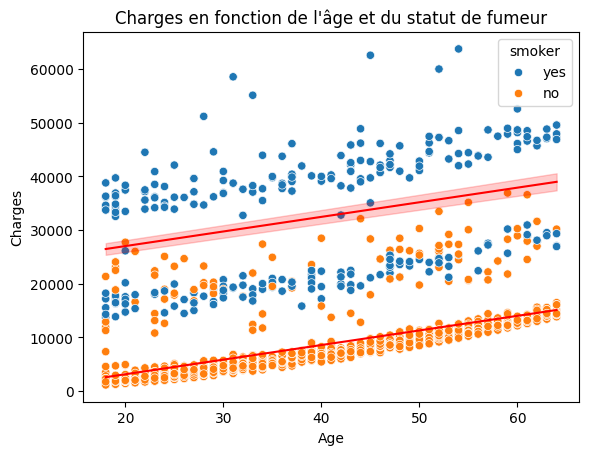

In [49]:
y = data_processed["charges"]
X = data_processed.drop("charges", axis=1)
X = X[["const","age","smoker_yes"]]
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
results = sm.OLS(y_train,X_train).fit()
print(results.bse)

age_range = np.linspace(data_processed['age'].min(), data_processed['age'].max(), 200)
charges_pred_non_fumeur = results.params[0] + results.params[1]*age_range + results.params[2]*0
charges_pred_fumeur = results.params[0] + results.params[1]*age_range + results.params[2]*1

se_pred_fumeur = np.sqrt(results.bse[0]**2 + (age_range*results.bse[1])**2 + (1*results.bse[2])**2)
se_pred_non_fumeur = np.sqrt(results.bse[0]**2 + (age_range*results.bse[1])**2 + (0*results.bse[2])**2)

lower_fumeur = charges_pred_fumeur - 1.96*se_pred_fumeur
upper_fumeur = charges_pred_fumeur + 1.96*se_pred_fumeur

lower_non_fumeur = charges_pred_non_fumeur - 1.96*se_pred_non_fumeur
upper_non_fumeur = charges_pred_non_fumeur + 1.96*se_pred_non_fumeur



sns.scatterplot(data = data, y = "charges",x = "age",hue="smoker")
plt.title("Charges en fonction de l'âge et du statut de fumeur")
plt.plot(age_range, charges_pred_non_fumeur, color='red', label='Droite de régression sans fumeur')
plt.plot(age_range, charges_pred_fumeur, color='red', label='Droite de régression avec fumeur')
plt.fill_between(age_range, lower_fumeur, upper_fumeur, color='red', alpha=0.2, label='IC 95%')

plt.xlabel("Age")
plt.ylabel("Charges")
plt.plot()

On peut maintenant essayer de prédire les charges à partir du BMI. D'après le graphe fait précédement, le coefficient semble cette fois différent selon l'état fumeur ou non.\
On va donc entraîner deux modèles de régression linéaire sur ces deux populations.

In [50]:
data_processed_fumeur = data_processed[data_processed["smoker_yes"]==1].reset_index()
data_processed_non_fumeur  = data_processed[data_processed["smoker_yes"]==0].reset_index()
y_fumeur = data_processed_fumeur["charges"]
X_fumeur = data_processed_fumeur.drop("charges", axis=1)



#Modèle pour les non fumeurs
y_non_fumeur = data_processed_non_fumeur["charges"]
X_non_fumeur = data_processed_non_fumeur.drop("charges", axis=1)
X_non_fumeur = X_non_fumeur[["const","bmi"]]

X_train, X_test, y_train,y_test = train_test_split(X_non_fumeur,y_non_fumeur, test_size=0.2, random_state=42)

results = sm.OLS(y_train,X_train).fit()
print(results.summary())

#Modèle pour les fumeurs
y_fumeur = data_processed_fumeur["charges"]
X_fumeur = data_processed_fumeur.drop("charges", axis=1)
X_fumeur = X_fumeur[["const","bmi"]]

X_train, X_test, y_train,y_test = train_test_split(X_fumeur,y_fumeur, test_size=0.2, random_state=42)

results = sm.OLS(y_train,X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.763
Date:                Sun, 30 Nov 2025   Prob (F-statistic):            0.00539
Time:                        22:19:39   Log-Likelihood:                -17887.
No. Observations:                1766   AIC:                         3.578e+04
Df Residuals:                    1764   BIC:                         3.579e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6474.6295    745.367      8.687      0.0

[]

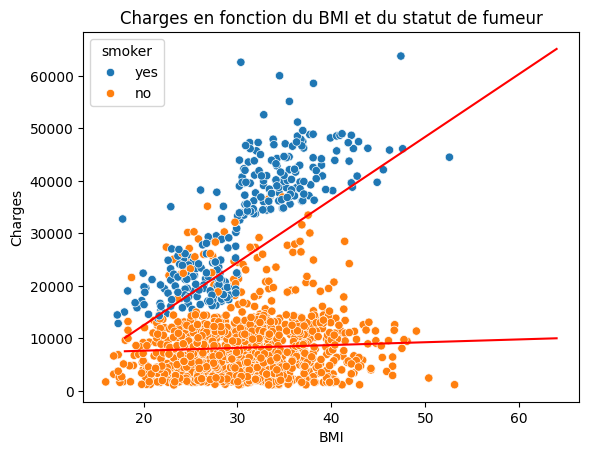

In [51]:
#A finir
bmi_range  = np.linspace(data_processed['bmi'].min(), data_processed['bmi'].max(), 200)
charges_pred_non_fumeur = 6474.6295 + 66.4534*bmi_range 
charges_pred_fumeur = -1.354e+04 + 1480.6659*bmi_range

sns.scatterplot(data = data, y = "charges",x = "bmi",hue="smoker")
plt.title("Charges en fonction du BMI et du statut de fumeur")
plt.plot(age_range, charges_pred_non_fumeur, color='red', label='Droite de régression sans fumeur')
plt.plot(age_range, charges_pred_fumeur, color='red', label='Droite de régression avec fumeur')

plt.xlabel("BMI")
plt.ylabel("Charges")
plt.plot()

On aurait donc ces modèles là. Cependant, les R2 de ces modèles ne sont vraiment pas bons avec BMI seuls, on va donc garder la combinaison avec les autres variables.\
On va faire un modèle avec 

In [52]:
##Stepwise model selection : backward
y = data_processed["charges"]
col = data_processed.columns
col = col.drop("charges")
list_col = col

for var in col:
    
    print("\nVariables used :")
    if(len(list_col.to_list())>0):
        print(list_col.to_list())
        X = data_processed[list_col]

        X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

        results = sm.OLS(y_train,X_train).fit()
        print(results.summary())

        list_col = list_col.drop(var) 
    else:
        print("Backward ended")


Variables used :
['const', 'age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     844.2
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:19:39   Log-Likelihood:                -22432.
No. Observations:                2217   AIC:                         4.488e+04
Df Residuals:                    2208   BIC:                         4.493e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t 

## Test avec modif

Revoir

Text(0.5, 1.0, 'Distribution de log(charges)')

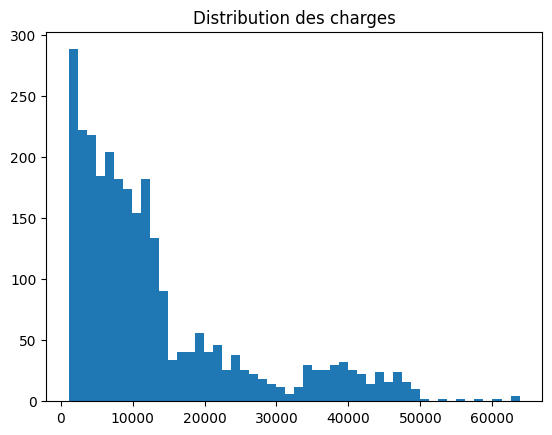

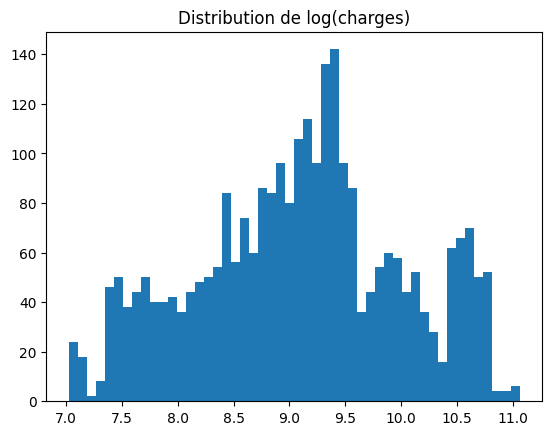

In [53]:
df["log_charges"] = np.log(df["charges"])

plt.figure()
plt.hist(df["charges"], bins=50)
plt.title("Distribution des charges")

plt.figure()
plt.hist(df["log_charges"], bins=50)
plt.title("Distribution de log(charges)")


On observe qu'il serait peut etre utile de faire une observation de log charges plutot que charges, et de retrouver les valeurs plus tard.

<Axes: xlabel='bmi_cat', ylabel='charges'>

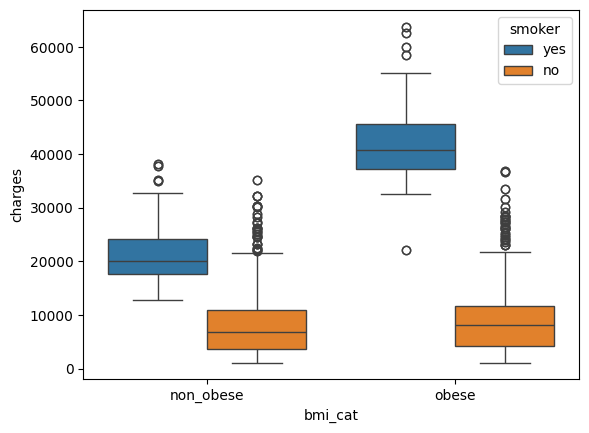

In [54]:
df["bmi_cat"] = np.where(df["bmi"] >= 30, "obese", "non_obese")

sns.boxplot(data=df, x="bmi_cat", y="charges", hue="smoker")

Les boxplots corroborent l'information que l'effet "obesité" est beaucoup plus fort chez les fumeurs que chez les non fumeurs.
Precisement, on observe quasi aucune différence entre les non fumeurs non obeses et les non fumeurs obeses
En revanche, le fait de fumer change grandement les charges, comme observé, et cet effet est accru par l'obesité.

In [55]:



df["log_charges"] = np.log(df["charges"])

formula = "log_charges ~ age + smoker + bmi_cat + smoker:bmi_cat + children + sex + region"

glm_log = smf.glm(formula=formula,
                  data=df,
                  family=sm.families.Gaussian()).fit()

print(glm_log.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            log_charges   No. Observations:                 2772
Model:                            GLM   Df Residuals:                     2762
Model Family:                Gaussian   Df Model:                            9
Link Function:               Identity   Scale:                         0.18315
Method:                          IRLS   Log-Likelihood:                -1575.6
Date:                Sun, 30 Nov 2025   Deviance:                       505.86
Time:                        22:19:40   Pearson chi2:                     506.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9744
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Une regression lineaire sur le log charges offre deja 0.975 de R²

Il y plusieurs informations importantes:
pour un fumeur non obese, il y a exp(1.21)=3.4 fois plus de charges qu'un non fumeur non obese
pour un obese non fumeur, il y a exp(0.2)=1.23 fois plus de charges qu'un non fumeur non obese

De surcroit, il y a un coefficient exp(0.65)=1.91 fois plus de charges en plus lorsque l'on est fumeur et obese.

# Modèle Gamma

In [92]:
y = data_processed["charges"]
X = data_processed.drop("charges", axis=1)

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

gamma_model = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()

print(gamma_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:                 2217
Model:                            GLM   Df Residuals:                     2208
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.45401
Method:                          IRLS   Log-Likelihood:                -22045.
Date:                Sun, 30 Nov 2025   Deviance:                       543.15
Time:                        23:02:49   Pearson chi2:                 1.00e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.6906
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8921      0.067  

c:\Users\ulyss\Bureau\Cours\0 Supérieur\A4\1 Premier Semestre\0 Mathématiques\General Linar Models\Projet\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning:

The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.



# Modèle XGBoost

In [85]:
databoost = data_processed.copy()
databoost["log_charges"] = np.log(databoost["charges"])
databoost.drop(["charges","const"],axis = 1, inplace=True)
databoost.head()

,age,bmi,children,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,log_charges
0,19,27.900,0,0,1,0,0,0,1,9.734176
1,18,33.770,1,1,0,0,0,1,0,7.453302
2,28,33.000,3,1,0,0,0,1,0,8.400538
3,33,22.705,0,1,0,0,1,0,0,9.998092
4,32,28.880,0,1,0,0,1,0,0,8.260197


In [65]:
# databoost = data.copy()
# databoost["sex_male"] = (databoost["sex"] == "male").astype(int)
# databoost["smoker_yes"] = (databoost["smoker"] == "yes").astype(int)
# databoost["log_charges"] = np.log(databoost["charges"])
# databoost = databoost.drop(columns=["sex", "smoker", "charges"])
# region_dummies = pd.get_dummies(databoost["region"], prefix="region").astype(int)
# databoost = pd.concat(
#     [databoost.drop(columns=["region"]), region_dummies],
#     axis=1
# )
# databoost.head()

On a prépare le jeu de données databoost de sorte à ne plus avoir de valeurs non numériques et d'avoir les charges médicale en échelle logarithmiques. \
On lance un modèle de machine learning non-GLM que nous avons pu étudier : XGBoost. Cet algorithme est très performant peu importe la tâche confiée. 


In [86]:
features = [c for c in databoost.columns if c != "log_charges"]
X = databoost[features]
y = databoost["log_charges"]

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

model_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=0,
    n_jobs=-1
)

model_xgb.fit(X_train, y_train)

y_pred_log = model_xgb.predict(X_test)
rmse_log = root_mean_squared_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)
adj_r2_log = 1-(1-r2_log)*(len(y_test)-1)/(len(y_test)-10-1) #On a 10 variables explicatives

print("RMSE (log_charges):", rmse_log)
print("R² (log_charges):", r2_log)
print("Adjusted R² (log_charges) :", adj_r2_log)

RMSE (log_charges): 0.35931716418016957
R² (log_charges): 0.8626382301184636
Adjusted R² (log_charges) : 0.8601131975838766


Les résultats sont déjà très bons, on ajoute aussi le concept de "kfoldclassifier", ca permet de limiter un peu le biais par rapport à la répartition du dataset Train.

In [78]:
features = [c for c in databoost.columns if c != "log_charges"]
X = databoost[features]
y = databoost["log_charges"]

#X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42) #Pas nécessaire car on utilise un K-Fold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

model_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=0,
    n_jobs=-1
)

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
}

cv_results = cross_validate(
    model_xgb,
    X,
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

rmse_folds = -cv_results["test_rmse"]
r2_folds = cv_results["test_r2"]
adj_r2_log = 1-(1-r2_folds.mean())*(len(y_test)-1)/(len(y_test)-10-1) #On a 10 variables

print("XGB RMSE moyen (log_charges):", rmse_folds.mean())
print("XGB RMSE par fold:", rmse_folds)
print("XGB R2 moyen (log_charges):", r2_folds.mean())
print("XGB R2 par fold:", r2_folds)


XGB RMSE moyen (log_charges): 0.31914846270325203
XGB RMSE par fold: [0.36051371 0.32774897 0.27941365 0.3077346  0.32033139]
XGB R2 moyen (log_charges): 0.8803206849205395
XGB R2 par fold: [0.86172187 0.87351554 0.90070609 0.89015044 0.87550949]


Un peu moins bon, ce n'est pas choquant, car l'information est plutot excellente de base, et il y a peu d'outlier, mais plutôt une ligne directive claire, tracée par les categories fumeurs et la colonne BMI.\
On perd alors de la précision à vouloir chercher des comportements sur des petits segments, lorsqu'il y a un comportement très visible dans l'ensemble, sans "imbalance" comme on peut voir en classification. \
On teste maintenant sur charges et non log charges.

In [89]:
databoost_no_log = data_processed.copy()
databoost_no_log.drop(["const"],axis = 1, inplace=True)
databoost_no_log.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,0,1,0,0


In [91]:
features = [c for c in databoost_no_log.columns if c != "log_charges"]
X = databoost_no_log[features]
y = databoost_no_log["charges"]

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42) 


model_xgb_nolog = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=0,
    n_jobs=-1
)
model_xgb_nolog.fit(X_train, y_train)
y_pred = model_xgb_nolog.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(len(y_test)-1)/(len(y_test)-10-1) #On a 10 variables explicatives

print("RMSE (charges):", rmse)
print("R2 (charges):", r2)
print("Adjusted R² (charges) :", adj_r2)

RMSE (charges): 429.7128972841638
R2 (charges): 0.9987968984720331
Adjusted R² (charges) : 0.998774782635122


Legerement mieux, (revoir)

XGBoost : on perd complètement l'interprétabilité des résultats